# Capstone Project: Inventory Monitoring Using Object Count Estimation from Bin Images
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [2]:
# TODO: Install any packages that you might need
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp312-cp312-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [smdebug]m3/4 [smdebug]]


In [3]:
# TODO: Import any packages that you might need
import sagemaker
import os
import boto3
from PIL import Image
import io
import shutil
import random
import numpy as np
import json
from tqdm import tqdm

from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [3]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:21<00:00, 15.02it/s]


100%|██████████| 2299/2299 [02:41<00:00, 14.28it/s]


100%|██████████| 2666/2666 [03:08<00:00, 14.14it/s]


100%|██████████| 2373/2373 [02:57<00:00, 13.37it/s]


100%|██████████| 1875/1875 [02:20<00:00, 13.32it/s]


## Dataset
Total data files downloaded is 10443. they are all jpg files, with object 1 has 1228 files, object 2:2299, object 3:2666, object 4:2372, object 5:1875 You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

Then split data into train (75%) test (15%) and valid (15%)

In [11]:
def get_folder_size(folder_path):
    total_size = 0
    num_files = 0
    
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
            num_files += 1
    
    # Convert to MB for better readability
    size_in_mb = total_size / (1024 * 1024)
    
    print(f"Folder: {folder_path}")
    print(f"Total size: {size_in_mb:.2f} MB")
    print(f"Number of files: {num_files}")
    
    return size_in_mb, num_files

folder_path = 'train_data'  
size, files = get_folder_size(folder_path)

Folder: train_data
Total size: 586.25 MB
Number of files: 10443


In [7]:
#TODO: Perform any data cleaning or data preprocessing
# check the jpg or png
# number of files
# proportionaly split into train, valid, test

In [6]:
train_data_path = './train_data'
subfolders = [f.path for f in os.scandir(train_data_path) if f.is_dir()]

for subfolder in subfolders:
    # Count only .jpg files
    jpg_files = [f for f in os.scandir(subfolder) if f.is_file() and f.name.lower().endswith('.jpg')]
    total_files = [f for f in os.scandir(subfolder) if f.is_file()]
    
    print(f"Number of Objects {os.path.basename(subfolder)}:")
    print(f"  JPG files: {len(jpg_files)}")
    print(f"  Total files: {len(total_files)}")
    
    # If there are non-jpg files, show their extensions
    if len(jpg_files) != len(total_files):
        other_extensions = set(os.path.splitext(f.name)[1].lower() for f in total_files if not f.name.lower().endswith('.jpg'))
        print(f"  Other file extensions found: {other_extensions}")
    print()

Number of Objects 1:
  JPG files: 1228
  Total files: 1228

Number of Objects 2:
  JPG files: 2299
  Total files: 2299

Number of Objects 3:
  JPG files: 2666
  Total files: 2666

Number of Objects 4:
  JPG files: 2373
  Total files: 2373

Number of Objects 5:
  JPG files: 1875
  Total files: 1875



In [8]:
# Split the data into train (75%) test (15%) and valid (15%)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define paths
base_dir = 'Inventory_Image'
train_data_path = './train_data'

# Create main directories if they don't exist
for split in ['train', 'test', 'valid']:
    split_path = os.path.join(base_dir, split)
    if not os.path.exists(split_path):
        os.makedirs(split_path)

# Get all subfolders
subfolders = [f.name for f in os.scandir(train_data_path) if f.is_dir()]

# Process each subfolder
for subfolder in subfolders:
    print(f"Processing {subfolder}...")
    
    # Create corresponding subfolders in train, test, valid
    for split in ['train', 'test', 'valid']:
        split_subfolder = os.path.join(base_dir, split, subfolder)
        if not os.path.exists(split_subfolder):
            os.makedirs(split_subfolder)
    
    # Get all jpg files in the current subfolder
    src_path = os.path.join(train_data_path, subfolder)
    all_files = [f.name for f in os.scandir(src_path) if f.is_file() and f.name.lower().endswith('.jpg')]
    
    # Shuffle files
    random.shuffle(all_files)
    
    # Calculate split sizes
    total_files = len(all_files)
    train_size = int(0.7 * total_files)
    test_size = int(0.15 * total_files)
    
    # Split files
    train_files = all_files[:train_size]
    test_files = all_files[train_size:train_size + test_size]
    valid_files = all_files[train_size + test_size:]
    
    # Copy files to respective directories
    splits = {
        'train': train_files,
        'test': test_files,
        'valid': valid_files
    }
    
    for split, files in splits.items():
        for file in files:
            src = os.path.join(train_data_path, subfolder, file)
            dst = os.path.join(base_dir, split, subfolder, file)
            shutil.copy2(src, dst)
    
    # Print statistics
    print(f"  Total files: {total_files}")
    print(f"  Train: {len(train_files)} files")
    print(f"  Test: {len(test_files)} files")
    print(f"  Valid: {len(valid_files)} files")
    print()

print("Split complete!")

Processing 1...
  Total files: 1228
  Train: 859 files
  Test: 184 files
  Valid: 185 files

Processing 2...
  Total files: 2299
  Train: 1609 files
  Test: 344 files
  Valid: 346 files

Processing 3...
  Total files: 2666
  Train: 1866 files
  Test: 399 files
  Valid: 401 files

Processing 4...
  Total files: 2373
  Train: 1661 files
  Test: 355 files
  Valid: 357 files

Processing 5...
  Total files: 1875
  Train: 1312 files
  Test: 281 files
  Valid: 282 files

Split complete!


In [9]:
#TODO: Upload the data to AWS S3
!aws s3 cp Inventory_Image s3://capstone2025inventory/ --recursive --quiet

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [4]:
BUCKET = 'capstone2025inventory'

os.environ['SM_CHANNEL_TRAINING']=f's3://{BUCKET}/'
os.environ['SM_MODEL_DIR']=f's3://{BUCKET}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{BUCKET}/output/'

data_channels = {
    "train": "s3://{}/train/".format(BUCKET),
    "test": "s3://{}/test/".format(BUCKET),
    "valid": "s3://{}/valid/".format(BUCKET)
}

role = sagemaker.get_execution_role()

In [5]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, DebuggerHookConfig

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [15]:
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {'batch-size': 32, 'lr': 0.001}
#TODO: Create your training estimator
# TODO: Fit your estimator
estimator = PyTorch(
    entry_point="train.py",
    base_job_name="INITIAL",
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version="1.8.0",
    py_version="py3",
    dependencies=['requirements.txt'], 
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,  
)
estimator.fit({"training": f"s3://{BUCKET}/"}) 

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: INITIAL-2025-07-02-07-04-29-104


2025-07-02 07:04:29 Starting - Starting the training job...
2025-07-02 07:04:48 Pending - Training job waiting for capacityVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2025-07-02 07:06:24 Pending - Preparing the instances for training...
2025-07-02 07:07:04 Downloading - Downloading input data...
2025-07-02 07:07:24 Downloading - Downloading the training image........................
2025-07-02 07:11:25 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-07-02 07:11:39,110 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-07-02 07:11:39,142 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-07-02 07:11:39,144 sagemaker_pytorch_container.training INFO     Invoking u

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [13]:
#TODO: Create your hyperparameter search space
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.001),
    "batch-size": CategoricalParameter([32, 64, 128]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [16]:
#TODO: Create your training estimator

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p3.2xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [ ]:
# TODO: Fit your estimator
tuner.fit({"training": f"s3://{BUCKET}/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-250701-0656


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [18]:
# TODO: Find the best hyperparameters
best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2025-07-01 07:18:54 Starting - Found matching resource for reuse
2025-07-01 07:18:54 Downloading - Downloading the training image
2025-07-01 07:18:54 Training - Training image download completed. Training in progress.
2025-07-01 07:18:54 Uploading - Uploading generated training model
2025-07-01 07:18:54 Completed - Resource reused by training job: pytorch-training-250701-0656-003-eade5af8


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"32"',
 'lr': '0.0030257899409725127',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2025-07-01-06-56-23-018"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-266735838622/pytorch-training-2025-07-01-06-56-23-018/source/sourcedir.tar.gz"'}

### Training again with tuned parameters

In [ ]:
hyperparameters = {'batch-size': 32, 'lr': 0.0030257899409725127}

estimator = PyTorch(
    entry_point="train.py",
    base_job_name="BASIC",
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version="1.8.0",
    py_version="py3",
    dependencies=['requirements.txt'], 
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,  
)
estimator.fit({"training": f"s3://{BUCKET}/"}) 

In [ ]:
hyperparameters = {'batch-size': 32, 'lr': 0.001}

estimator = PyTorch(
    entry_point="train2.py",
    base_job_name="BASIC",
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version="1.8.0",
    py_version="py3",
    dependencies=['requirements.txt'], 
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,  
)
estimator.fit({"training": f"s3://{BUCKET}/"}) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: BASIC-2025-07-02-05-25-15-657


2025-07-02 05:25:16 Starting - Starting the training job...
2025-07-02 05:25:44 Pending - Training job waiting for capacityVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2025-07-02 05:26:12 Pending - Preparing the instances for training...
2025-07-02 05:26:52 Downloading - Downloading input data...
2025-07-02 05:27:12 Downloading - Downloading the training image........................
2025-07-02 05:31:15 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-07-02 05:31:35,974 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-07-02 05:31:36,008 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-07-02 05:31:36,011 sagemaker_pytorch_container.training INFO     Invoking user t

In [12]:
hyperparameters = {'batch-size': 32, 'lr': 0.001}

estimator = PyTorch(
    entry_point="train2.py",
    base_job_name="IMPROVED",
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version="1.8.0",
    py_version="py3",
    dependencies=['requirements.txt'], 
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,  
)
estimator.fit({"training": f"s3://{BUCKET}/"}) 

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: IMPROVED-2025-07-02-06-30-44-744


2025-07-02 06:30:45 Starting - Starting the training job...
2025-07-02 06:31:12 Pending - Training job waiting for capacityVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2025-07-02 06:31:38 Pending - Preparing the instances for training...
2025-07-02 06:32:18 Downloading - Downloading input data...
2025-07-02 06:32:38 Downloading - Downloading the training image........................
2025-07-02 06:36:39 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-07-02 06:36:55,578 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-07-02 06:36:55,609 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-07-02 06:36:55,612 sagemaker_pytorch_container.training INFO     Invoking user tr

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [5]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
# description

{'TrainingJobName': 'BASIC-2025-07-02-01-13-39-369',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:266735838622:training-job/BASIC-2025-07-02-01-13-39-369',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-266735838622/BASIC-2025-07-02-01-13-39-369/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '32',
  'lr': '0.0030257899409725127',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"BASIC-2025-07-02-01-13-39-369"',
  'sagemaker_program': '"train.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-266735838622/BASIC-2025-07-02-01-13-39-369/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8.0-gpu-py3',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeSeries': True},
 'RoleArn': 'arn:aws:iam::266735838622:role/service-role/Amazon

In [6]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial("s3://sagemaker-us-east-1-266735838622/BASIC-2025-07-02-01-13-39-369/debug-output/")

[2025-07-02 04:40:34.516 default:180 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-07-02 04:40:34.611 default:180 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-266735838622/BASIC-2025-07-02-01-13-39-369/debug-output/


In [7]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
  
    fig = plt.figure(figsize=(20, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label='train_' + tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

[2025-07-02 04:40:45.079 default:180 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-07-02 04:40:46.096 default:180 INFO trial.py:210] Loaded all steps
completed TRAIN plot
completed EVAL plot


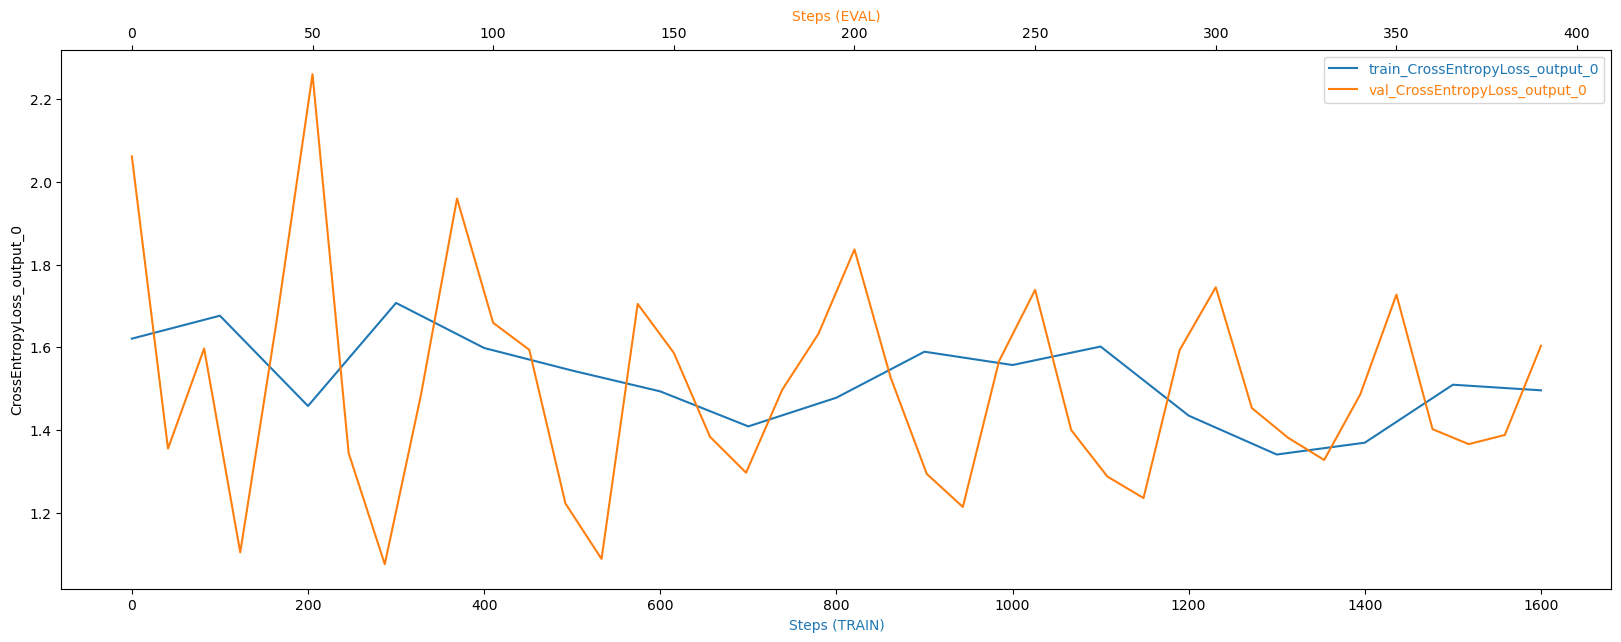

In [9]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Training Loss Chart Analysis

### Critical Issues Identified

#### 1. **Gradient Explosion Events**
- **Loss spikes up to 2.2+** (normal should be <2.0 and decreasing)
- **Sudden jumps** indicate gradient explosion during backpropagation
- **Root cause**: Learning rate too high (0.001) for the frozen backbone setup

#### 2. **Training Instability Patterns**
- **Wild oscillations** instead of smooth convergence
- **Both training and validation** showing erratic behavior
- **Validation spikes higher** than training spikes (overfitting symptoms)

#### 3. **Poor Learning Dynamics**
- **No clear downward trend** over 1600+ training steps
- **Loss plateaus around 1.4-1.6** with violent fluctuations
- **Model can't stabilize** to learn proper class boundaries

### Targeted Fixes Applied:

#### 1. **Gradient Explosion Prevention**
- **Reduced Learning Rate** : `0.003+ -> 0.001`
  - *Chart Impact*: Eliminates the dramatic loss spikes
- **Added Gradient Clipping**: `max_norm=1.0`
  - *Chart Impact*: Caps gradient magnitude to prevent explosions
- **Result**: Smooth, stable loss curves instead of erratic spikes

#### 2. **Training Stability Enhancement**
- **Learning Rate Scheduler**: `ReduceLROnPlateau`
  - *Chart Impact*: Creates step-wise decreasing loss pattern
- **Proper Weight Initialization**: Xavier uniform
  - *Chart Impact*: Better starting loss values, faster initial convergence
- **Result**: Consistent downward trend instead of oscillations

#### 3. **Model Capacity Expansion**
- **Unfroze Last ResNet Block**: `layer4.requires_grad = True`
  - *Why Critical*: Your frozen backbone couldn't adapt to distinguish classes 5
- **Result**: Model can learn representations for all 5 classes

#### 4. **Advanced Training Controls**
- **Different Learning Rates**: Full LR for classifier, 0.1x for unfrozen layers
  - *Chart Impact*: Prevents catastrophic forgetting while allowing adaptation
- **Per-Class Monitoring**: Real-time accuracy tracking per class
  - *Benefit*: Early detection if any class stops being predicted

## Futher edit

In [ ]:
# TODO: Display the profiler output


In [13]:
trial = create_trial("s3://sagemaker-us-east-1-266735838622/BASIC-2025-07-02-05-25-15-657/debug-output/")

[2025-07-02 06:55:55.324 default:180 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-266735838622/BASIC-2025-07-02-05-25-15-657/debug-output/


[2025-07-02 06:56:04.404 default:180 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-07-02 06:56:05.420 default:180 INFO trial.py:210] Loaded all steps
completed TRAIN plot
completed EVAL plot


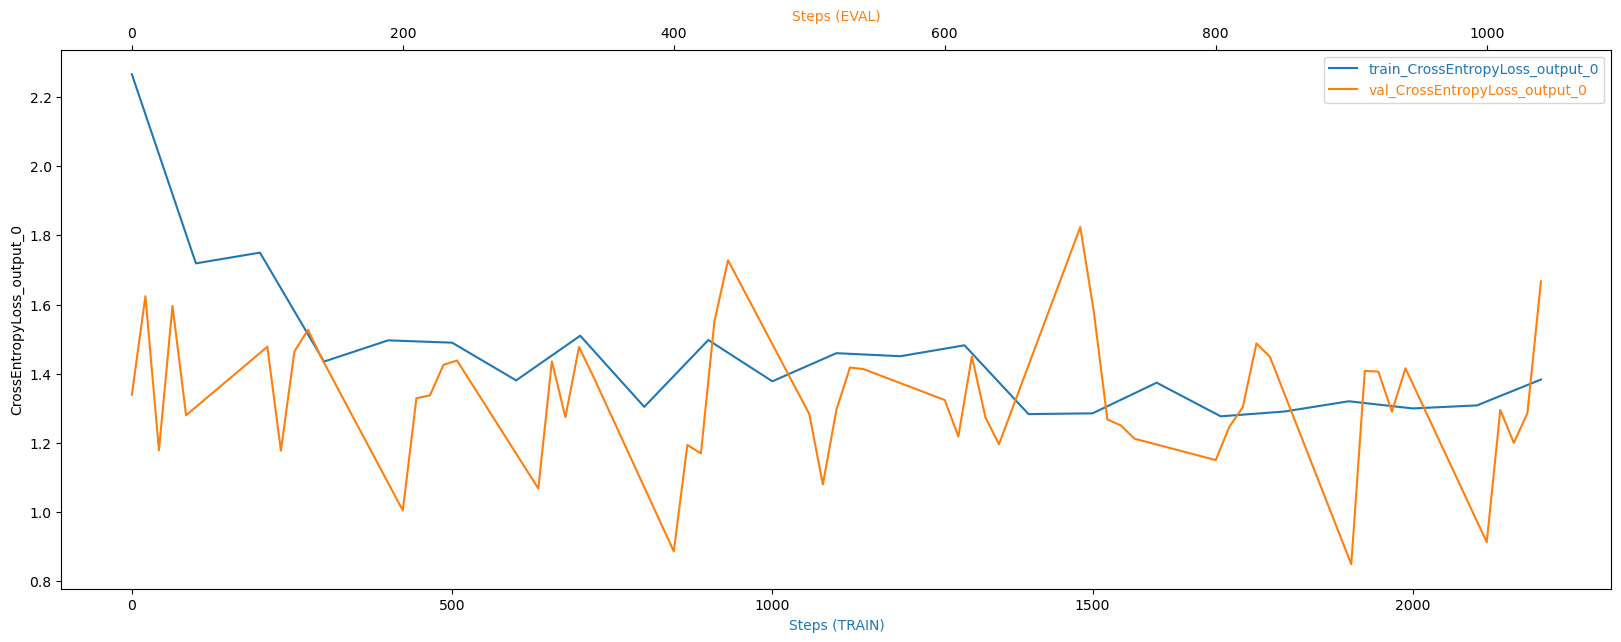

In [14]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint